# Realizing Velocity Prediction with CNN

This part of the notebook attempts to realize the velocity prediction with CNN as opposed to the LSTM models used in the original [paper](https://arxiv.org/pdf/1708.03535.pdf). 

In [1]:
import os
import mido
import keras
import numpy as np
import sklearn.model_selection as ms
import StyleNet.midi_util as midi_util
import matplotlib.pyplot as plt

Using TensorFlow backend.


88


### Part 1 Loading and processing data

In this part we would first process the data into a form that we can use. We will be reusing code from the [GitHub repo](https://github.com/imalikshake/StyleNet) of the paper author to process the data the way he did it.

First, we use the code to convert it into the format that they provided

In [2]:
fpath = "TPD/classical/bach_846_format0.mid"
midi = mido.MidiFile(fpath)
midi_array, velocity_array = midi_util.midi_to_array_one_hot(midi, 4)

Now we inspect the data that we loaded

In [ ]:
print "midi_array shape = %s" % str(midi_array.shape)
print "velocity_array shape = %s" % str(velocity_array.shape)

Now we attempt to divide up the midi_array into 2 layers, so the data would be a volumn instead of a 1d array. This may allow us to learn better features through convolution.

In [ ]:
midi_notes = midi_array[:, ::2]
midi_continuation = midi_array[:, 1::2]
X = np.dstack((midi_notes, midi_continuation))
print "X shape = %s" % str(X.shape)

This can be generalized to loading and converting an entire subset of music files. The code to do that is below

In [138]:
def load_midis(base_fpath):
    fpaths = []
    for (root, dirnames, filenames) in os.walk(base_fpath):
        fpaths += [os.path.join(root, filename) for filename in filenames]
    return [mido.MidiFile(fpath) for fpath in fpaths]

def convert_midis(midis):
    X = []
    Y = []
    for midi in midis:
        try:
            midi_array, velocity_array = midi_util.midi_to_array_one_hot(midi, 4)
        except:
            continue
        midi_notes = midi_array[:, ::2]
        midi_continuation = midi_array[:, 1::2]
        X_i = np.dstack((midi_notes, midi_continuation))
        if (X_i.shape[0] > 1000):
            X += [X_i]
            Y += [velocity_array]
    return X, Y

In [ ]:
X, Y = convert_midis(load_midis("TPD/classical"))

In [140]:
print "X's length is %s" % str(len(X))
print "X[0]'s shape is %s" % str(X[0].shape)
print "Y's length is %s" % str(len(Y))
print "Y[0]'s shape is %s" % str(Y[0].shape)

X's length is 150
X[0]'s shape is (2048, 88, 2)
Y's length is 150
Y[0]'s shape is (2048, 88)


Now we can store these matricies and load them later so we don't loose them. Note that the shapes of these matricies are not what we intended and needs further processing. The X matrix contains 183 3D matricies but it iself is not a 4D matrix because each matrix within it does not have the same dimention. In order to solve this problem we need to either pad the songs so that they are the same time, or end songs early and only take a sample from the song so we can make the matricies the same dimension. 

So now we will see the minimum size of the songs and take a sample of the same size from every song

In [141]:
print "Minimum shape of songs is %s" % str(min(X, key=lambda x: x.shape[0]).shape)

min_shape_X, _, _ = min(X, key=lambda x: x.shape[0]).shape
new_X = []
for X_i in X:
    new_X += [X_i[:min_shape_X, :, :]]
new_X = np.stack(new_X)

new_Y = []
for Y_i in Y:
    new_Y += [Y_i[:min_shape_X, :]]
new_Y = np.stack(new_Y)
print "Now the sizes of the matricies are X: %s, Y: %s"% (str(new_X.shape), str(new_Y.shape))

X, Y = new_X, new_Y

Minimum shape of songs is (1024, 88, 2)
Now the sizes of the matricies are X: (150, 1024, 88, 2), Y: (150, 1024, 88)


In [162]:
Y = np.expand_dims(Y, axis=3)
np.save("matricies/X.npy", X)
np.save("matricies/Y.npy", Y)

In [2]:
X = np.load("matricies/X.npy")
Y = np.load("matricies/Y.npy")

### Part 2 Modeling
Now we have represented our data, we would like to see if we can build a model that predicts the velocities through the 3D matrix we generated

In [3]:
X_train, X_test, Y_train, Y_test = ms.train_test_split(X, Y, test_size=0.1, random_state=43)
print X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(135, 1024, 88, 2) (15, 1024, 88, 2) (135, 1024, 88, 1) (15, 1024, 88, 1)


#### 2.1 Attempt to use a CNN of filter size (100, 1)

First we will try to use a CNN of filter size (100, 1) and see if we can correctly fit the velocity data.
The code block below will split the dataset into train and test datasets.

In [4]:
def model1(input_shape):
    X_input = keras.layers.Input(input_shape)
    X = keras.layers.Conv2D(filters=50, kernel_size=(100, 1), strides=(1, 1), padding='same', name='Conv0',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X_input)
    X = keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.Conv2D(filters=1, kernel_size=(200, 1), strides=(1, 1), padding='same', name='Conv2',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.Activation('relu')(X)
#     X = keras.layers.Flatten()(X)
    model = keras.models.Model(inputs=X_input, outputs=X, name='basic')
    return model

In [5]:
m1 = model1(input_shape=(1024, 88, 2))
m1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [6]:
m1.fit(X_train, Y_train, epochs = 20)

Epoch 1/20
135/135 [==============================] - 504s 4s/step - loss: 122.8744 - acc: 0.6739
Epoch 2/20
135/135 [==============================] - 469s 3s/step - loss: 86.4913 - acc: 0.7232
Epoch 3/20
135/135 [==============================] - 458s 3s/step - loss: 64.7377 - acc: 0.7857
Epoch 4/20
135/135 [==============================] - 460s 3s/step - loss: 51.6880 - acc: 0.8455
Epoch 5/20
135/135 [==============================] - 480s 4s/step - loss: 42.5139 - acc: 0.8661
Epoch 6/20
135/135 [==============================] - 463s 3s/step - loss: 36.5151 - acc: 0.8558
Epoch 7/20
135/135 [==============================] - 489s 4s/step - loss: 32.4295 - acc: 0.8502
Epoch 8/20
135/135 [==============================] - 478s 4s/step - loss: 28.8278 - acc: 0.8873
Epoch 9/20
135/135 [==============================] - 471s 3s/step - loss: 26.4903 - acc: 0.8864
Epoch 10/20
135/135 [==============================] - 552s 4s/step - loss: 24.6172 - acc: 0.9161
Epoch 11/20
135/135 [=======

In [8]:
m1.save('m1_conv.h5')

In [9]:
m1 = keras.models.load_model('m1_conv.h5')

In [10]:
preds = m1.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

15/15 [==============================] - 15s 1s/step
Loss = 14.922228813171387
Test Accuracy = 0.9465982913970947


In [12]:
Y_0_hat = m1.predict(np.expand_dims(X_test[0], axis=0))
Y_0_hat = Y_0_hat.reshape(1024, 88)

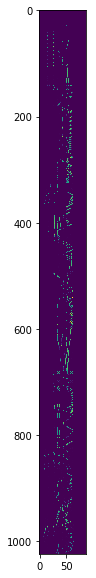

In [14]:
plt.figure(figsize = (200,10))
plt.imshow(Y_0_hat)

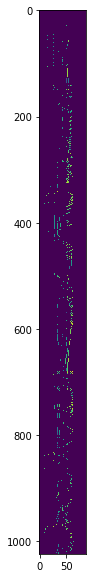

In [15]:
plt.figure(figsize = (200,10))
plt.imshow(Y_test[0].reshape(1024, 88))

#### 2.2 Attempt to use multiple CNN layers and filter size (100, 88) in the beginning

In [ ]:
def model2(input_shape):
    X_input = keras.layers.Input(input_shape)
    X = X_input
#     X = keras.layers.ZeroPadding2D(padding=(50, 0))(X)
#     X = keras.layers.ZeroPadding2D(padding=(4, 0))(X)
    X = keras.layers.Conv2D(filters=100, kernel_size=(10, 1), strides=(1, 1), padding='same', name='Conv0',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = keras.layers.Activation('relu')(X)
#     X = keras.layers.Reshape((1024, 176, 1))(X)
    print X.shape
    
#     X = keras.layers.ZeroPadding2D(padding=(50, 0))(X)
    X = keras.layers.Conv2D(filters=50, kernel_size=(101, 1), strides=(1, 1), padding='same', name='Conv1',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.BatchNormalization(axis = 3, name = 'bn1')(X)
    X = keras.layers.Activation('relu')(X)
#     X = keras.layers.Reshape((1024, 88, 2))(X)
    print X.shape
    
    X = keras.layers.Conv2D(filters=1, kernel_size=(201, 88), strides=(1, 1), padding='same', name='Conv2',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.Activation('relu')(X)
    print X.shape
    model = keras.models.Model(inputs=X_input, outputs=X, name='basic 2')
    return model

In [ ]:
m2 = model2(input_shape=(1024, 88, 2))
m2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
m2.fit(X_train, Y_train, epochs = 10)

In [55]:
preds = m2.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

15/15 [==============================] - 1s 98ms/step
[97.30217742919922, 0.0031205611303448677]


Now we can save the model and then load it from the file so we do not have to retrain it

In [ ]:
m2.save('m2_conv.h5')

In [ ]:
m2 = keras.models.load_model('m2_conv.h5')

In [47]:
Y_0_hat = m2.predict(np.expand_dims(X_test[0], axis=0))
Y_0_hat = Y_0_hat.reshape(1024, 88)
print Y_0_hat.shape

(1024, 88)


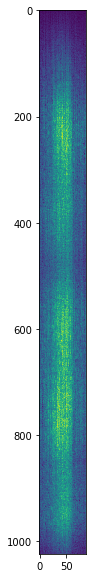

In [48]:
plt.figure(figsize = (200,10))
plt.imshow(Y_0_hat)

###### 2.3 Attempt to use Dilated CNN

In [7]:
def model3(input_shape):
    X_input = keras.layers.Input(input_shape)
    X = X_input
#     X = keras.layers.ZeroPadding2D(padding=(50, 0))(X)
#     X = keras.layers.ZeroPadding2D(padding=(4, 0))(X)
    X = keras.layers.Conv2D(filters=100, kernel_size=(101, 1), strides=(1, 1), padding='same', name='Conv0',
                            dilation_rate=(3, 1),
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = keras.layers.Activation('relu')(X)
#     X = keras.layers.Reshape((1024, 176, 1))(X)
    print X.shape
    
#     X = keras.layers.ZeroPadding2D(padding=(50, 0))(X)
#     X = keras.layers.Conv2D(filters=50, kernel_size=(101, 1), strides=(1, 1), padding='same', name='Conv1',
#                             kernel_initializer=keras.initializers.glorot_normal(seed=None),
#                             bias_initializer=keras.initializers.glorot_normal(seed=None),
#                             data_format="channels_last")(X)
#     X = keras.layers.BatchNormalization(axis = 3, name = 'bn1')(X)
#     X = keras.layers.Activation('relu')(X)
#     X = keras.layers.Reshape((1024, 88, 2))(X)
    print X.shape
    
    X = keras.layers.Conv2D(filters=1, kernel_size=(201, 88), strides=(1, 1), padding='same', name='Conv2',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.Activation('relu')(X)
    print X.shape
    model = keras.models.Model(inputs=X_input, outputs=X, name='basic 2')
    return model

In [8]:
m3 = model3(input_shape=(1024, 88, 2))
m3.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

(?, 1024, 88, 100)
(?, 1024, 88, 100)
(?, 1024, 88, 1)


In [ ]:
m3.fit(X_train, Y_train, epochs = 25)

Epoch 1/25


In [ ]:
preds = m3.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Now we can save the model and then load it from the file so we do not have to retrain it

In [ ]:
m3.save('m3_conv.h5')

In [ ]:
m3 = keras.models.load_model('m3_conv.h5')

In [47]:
Y_0_hat = m3.predict(np.expand_dims(X_test[0], axis=0))
Y_0_hat = Y_0_hat.reshape(1024, 88)
print Y_0_hat.shape

(1024, 88)


In [ ]:
plt.figure(figsize = (200,10))
plt.imshow(Y_0_hat)

Playground

In [207]:
np.max(np.sum((X[0] > 0), axis=1))

7